In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression



import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

In [133]:
data = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [59]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [60]:
data.sort_index(inplace=True)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [62]:
#resample the data by 1hour and find the mean to aggregate the values
data = data.resample('1H').mean()

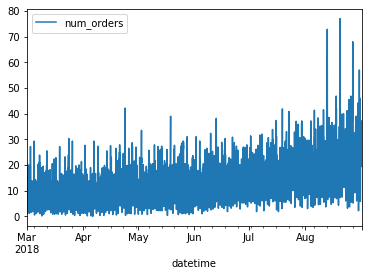

In [63]:
data.plot()

In [64]:
#data['rolling_mean'] = data.rolling(10).mean()

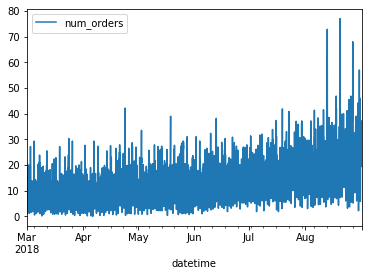

In [65]:
data.plot()

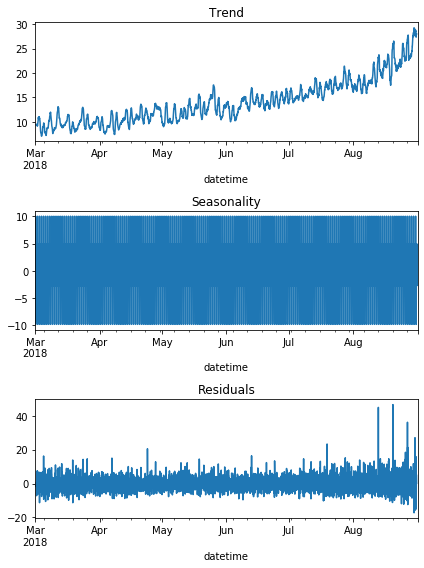

In [66]:
decomposed = seasonal_decompose(data)# < write code here >

plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
# < write code here >
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
# < write code here >
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [68]:
train, test = train_test_split(data, test_size=0.25, shuffle=False)

In [70]:
train.tail()

,num_orders
datetime,
2018-07-16 19:00:00,15.666667
2018-07-16 20:00:00,10.166667
2018-07-16 21:00:00,18.500000
2018-07-16 22:00:00,14.166667
2018-07-16 23:00:00,17.000000


In [71]:
test.head()

,num_orders
datetime,
2018-07-17 00:00:00,21.833333
2018-07-17 01:00:00,20.500000
2018-07-17 02:00:00,17.000000
2018-07-17 03:00:00,16.500000
2018-07-17 04:00:00,17.333333


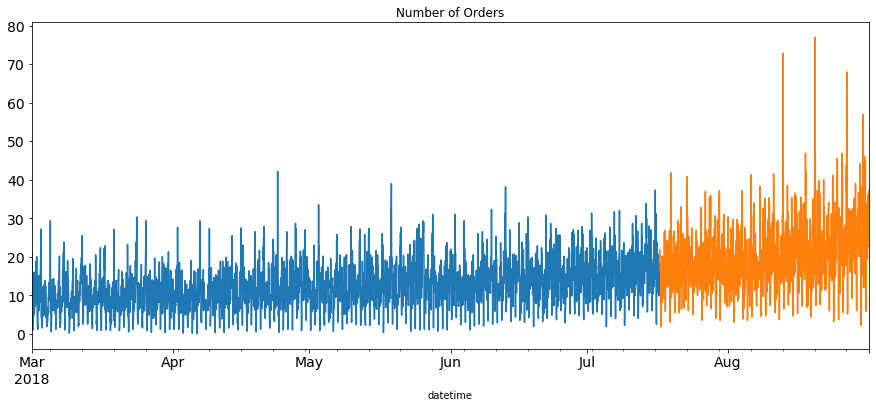

In [73]:
train.num_orders.plot(title='Number of Orders', figsize=(15, 6), fontsize=14)
test.num_orders.plot(title='Number of Orders', figsize=(15, 6), fontsize=14)
plt.show()

### Naive Approach

In [74]:
dd = np.asarray(train.num_orders)#features as an array
y_hat = test.copy()# test data

In [77]:
y_hat['naive'] = dd[len(dd)-1]

In [81]:
len(dd)-1

3311

In [90]:
#dd[3311]
train.iloc[-1]

num_orders    17.0
Name: 2018-07-16 23:00:00, dtype: float64

In [84]:
train.tail()

,num_orders
datetime,
2018-07-16 19:00:00,15.666667
2018-07-16 20:00:00,10.166667
2018-07-16 21:00:00,18.500000
2018-07-16 22:00:00,14.166667
2018-07-16 23:00:00,17.000000


In [91]:
y_hat.tail()

,num_orders,naive
datetime,,
2018-08-31 19:00:00,22.666667,17.0
2018-08-31 20:00:00,25.666667,17.0
2018-08-31 21:00:00,26.500000,17.0
2018-08-31 22:00:00,37.166667,17.0
2018-08-31 23:00:00,34.166667,17.0


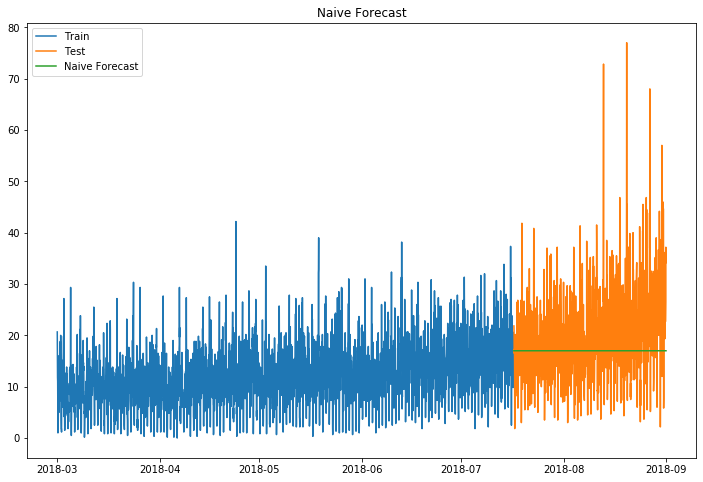

In [102]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train.index, train, label='Train')
ax.plot(test.index, test, label='Test')
ax.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
ax.legend()
ax.set_title('Naive Forecast')
plt.show()

In [100]:
naive_rmse = sqrt(mean_squared_error(test['num_orders'], y_hat['naive']))
print(naive_rmse)

9.261144383382383


### Simple Average

In [101]:
train['num_orders'].mean()

12.067733494363914

In [103]:
y_hat['average'] = train['num_orders'].mean()

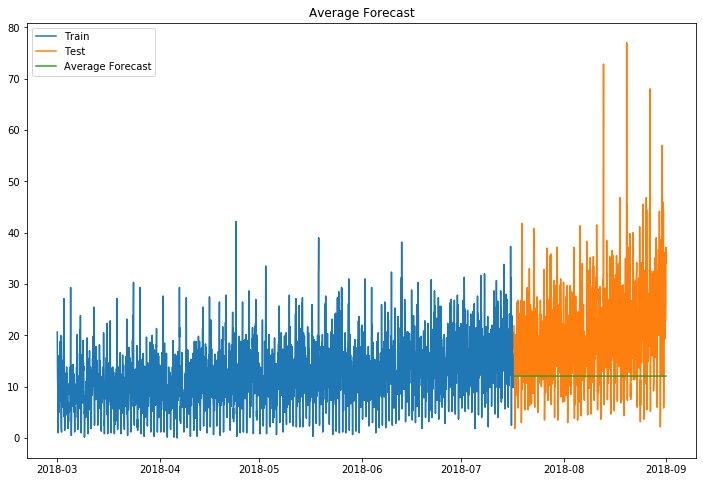

In [105]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train.index, train, label='Train')
ax.plot(test.index, test, label='Test')
ax.plot(y_hat.index, y_hat['average'], label='Average Forecast')
ax.legend(loc='best')
ax.set_title('Average Forecast')
plt.show()

In [106]:
average_rmse = sqrt(mean_squared_error(test['num_orders'], y_hat['average']))
print(average_rmse)

11.851815307620683


### Moving Average

In [117]:
y_hat['moving_average'] = train['num_orders'].rolling(100).mean().iloc[-1]

In [116]:
train['num_orders'].rolling(100).mean().iloc[-1]

16.88833333333335

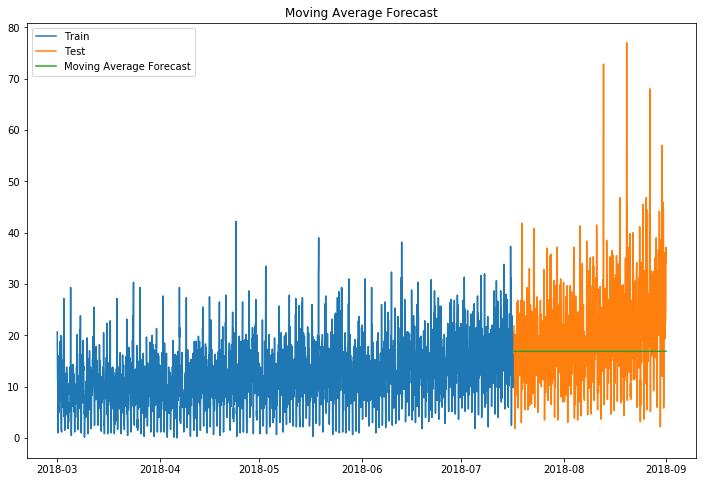

In [118]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train.index, train, label='Train')
ax.plot(test.index, test, label='Test')
ax.plot(y_hat.index, y_hat['moving_average'], label='Moving Average Forecast')
ax.legend(loc='best')
ax.set_title('Moving Average Forecast')
plt.show()

In [119]:
moving_average_rmse = sqrt(mean_squared_error(test['num_orders'], y_hat['moving_average']))
print(moving_average_rmse)

9.298861793585255


### Linear Regression training

In [134]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 6, 100)
#print(data.head(15))
#print(data.tail(15))

train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()

# < write code here >
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(21096, 11) (5300, 11) (21096,) (5300,)


In [135]:
model = LinearRegression()
model.fit(features_train, target_train)
train_pred = model.predict(features_train)
test_pred = model.predict(features_test)


print("RMSE for the training set:", sqrt(mean_squared_error(target_train, train_pred)))
print("RMSE for the test set: ", sqrt(mean_squared_error(target_test, test_pred)))

RMSE for the training set: 5.409457527147667
RMSE for the test set:  7.814759774710615
